In [1]:
# Working from 07. Data Subsetting and Transformation Services in the Cloud

In [1]:
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
import requests
from pprint import pprint
import datetime as dt
import s3fs
import xarray as xr
import matplotlib as plt
import hvplot
import numpy as np
%matplotlib inline

In [35]:
# don't need this unless we are making a general search
# url = 'https://cmr.earthdata.nasa.gov/search'
# collection_url = f'{url}/{"collections"}'

In [36]:
# Look up the dataset using the PO.DAAC faceted search 
#
# VIIRS L2
short_name = 'VIIRS_N20-OSPO-L2P-v2.61'
concept_id = 'C1996880450-POCLOUD'

# GOES L2 < - this fails because the data set is not "Harmony enabled" yet
# short_name = 'ABI_G17-STAR-L2P-v2.71'
# concept_id = 'C2036877626-POCLOUD'

In [37]:
# Set up harmony client
harmony_client = Client()

# Can AWS credentials step go here?

In [32]:
# FORMULATE SUBSET REQUEST
# ------------------------
request = Request(
    collection=Collection(id=concept_id),
    spatial=BBox(-81.0,32.0,-59.0,47.0),
    temporal={
        'start': dt.datetime(2021, 11, 16),
        'stop': dt.datetime(2021, 11, 17),
    },
)

# check syntax before submission
request.is_valid()

True

In [33]:
# submit the request
job_id = harmony_client.submit(request)

KeyError: 'jobID'

In [21]:
# check on status
harmony_client.status(job_id)

{'status': 'running',
 'message': 'The job is being processed',
 'progress': 0,
 'created_at': datetime.datetime(2021, 11, 19, 16, 30, 49, 210000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2021, 11, 19, 16, 30, 49, 210000, tzinfo=tzlocal()),
 'request': 'https://harmony.earthdata.nasa.gov/C1996880450-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(32.0%3A47.0)&subset=lon(-81.0%3A-59.0)&subset=time(%222021-11-16T00%3A00%3A00%22%3A%222021-11-17T00%3A00%3A00%22)',
 'num_input_granules': 9}

In [22]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [23]:
# retrieve list of output urls from completed query
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)

In [24]:
# eliminate from the list any files that are not named "subsetted" - they contain no data
valid_urls = list()
for u in urls:
    if u.endswith("subsetted.nc4"):
        valid_urls.append(u)
valid_urls

['s3://harmony-prod-staging/public/podaac/l2-subsetter/d6c14f5d-d3bb-4230-a9f5-172a2d3ff213/20211116055000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.61-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/d6c14f5d-d3bb-4230-a9f5-172a2d3ff213/20211116073000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.61-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/d6c14f5d-d3bb-4230-a9f5-172a2d3ff213/20211116153000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.61-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/d6c14f5d-d3bb-4230-a9f5-172a2d3ff213/20211116171000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.61-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/d6c14f5d-d3bb-4230-a9f5-172a2d3ff213/20211116185000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.61-v02.0-fv01.0_subsetted.nc4']

In [25]:
# AWS credentials
creds = harmony_client.aws_credentials()
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

In [26]:
# for now, just plot data for 1 granule
url = valid_urls[0]

In [27]:
# Open the url
f = s3_fs.open(url, mode='rb')
ds = xr.open_dataset(f)

In [28]:
# Apply corrections and quality flag to SST data
ds["sst_corrected"] = ds.sea_surface_temperature - ds.sses_bias - 273.15
ds["sst_cleaned"] = ds.sst_corrected.where(ds.quality_level == 5.0, np.nan) 

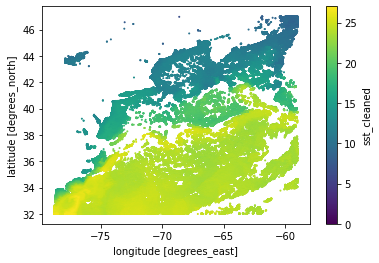

In [29]:
# Sanity check plot
ds.plot.scatter(x="lon", y="lat", s=1, hue="sst_cleaned", vmin=0) ;

In [17]:
# Load the model grid

In [18]:
# Use pyresample to 
import pyresample